In [1]:
import requests
import math
from datetime import datetime, timezone, timedelta
import pandas as pd
from pandas.io.json import json_normalize
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import numpy as np
from finta import TA

In [2]:
def download_ohlcv(symbol, start_date, end_date):
    date_iterator = start_date - timedelta(hours=1)
    
    ohlcv_df = pd.DataFrame()
    
    while date_iterator < end_date:
        delta = timedelta(seconds=min((end_date - date_iterator).total_seconds(), 2000 * 3600))
        limit = delta.total_seconds() // 3600 - 1
        date_iterator += delta
        
        params={
            'fsym': symbol,
            'tsym': 'USD',
            'limit': limit,
            'toTs': date_iterator.timestamp()
        }
        
        r = requests.get('https://min-api.cryptocompare.com/data/histohour', params=params)
        data = json_normalize(r.json(), record_path="Data")
        ohlcv_df = ohlcv_df.append(data)

    ohlcv_df['time'] = pd.to_datetime(ohlcv_df['time'], unit='s')
    ohlcv_df.set_index('time', inplace=True)
    ohlcv_df.rename(columns={'volumefrom': 'volume'}, inplace=True)
    ohlcv_df = ohlcv_df.tz_localize('UTC')
    
    return ohlcv_df

In [31]:
def download_trends(keyword, start_date, end_date):
    pytrends = TrendReq()

    delta = timedelta(days=7)
    date_iterator = start_date

    trends_df = pd.DataFrame()
    
    while date_iterator < end_date:
        week_start = date_iterator.strftime('%Y-%m-%dT%H')
        week_end = (date_iterator + delta).strftime('%Y-%m-%dT%H')
        tf = week_start + ' ' + week_end

        pytrends.build_payload([keyword], timeframe=tf)
        week_df = pytrends.interest_over_time()

        if (not trends_df.empty):
            ratio = trends_df[trends_df.index == date_iterator].iloc[0][keyword] / week_df[week_df.index == date_iterator].iloc[0][keyword]
            trends_df[keyword] /= ratio

        trends_df = trends_df.append(week_df)
        
        date_iterator += delta
        
    trends_df = trends_df[~trends_df.index.duplicated(keep='last')]
    trends_df.rename(columns={keyword: 'searches'}, inplace=True)
    trends_df.drop(columns='isPartial', inplace=True)
    trends_df['searches'] *= 100 / np.max(trends_df['searches'])
    trends_df = trends_df.tz_localize('UTC')
    
    return trends_df

In [25]:
start_date = datetime(2016, 1, 1, 0)
end_date = datetime(2018, 1, 1, 0)

In [28]:
ohlcv_df = download_ohlcv('BTC', start_date, end_date)

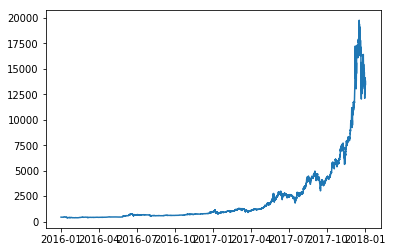

In [29]:
plt.plot(ohlcv_df.index.values, ohlcv_df['close'])

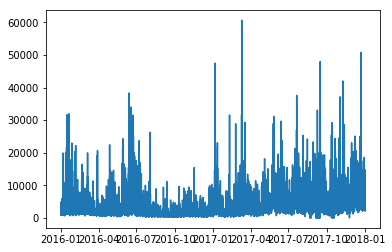

In [30]:
plt.plot(ohlcv_df.index.values, ohlcv_df['volume'])

In [41]:
trends_df = download_trends('Bitcoin', start_date, end_date)

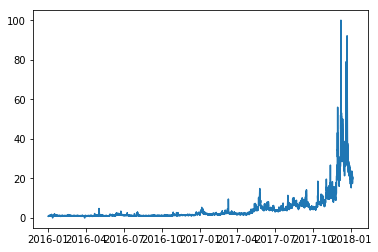

In [42]:
plt.plot(trends_df.index.values, trends_df['searches'])

In [35]:
df = ohlcv_df.join(trends_df, how="inner")

In [36]:
# add technical indicators - not totally sure about these yet
df = df.join(TA.MACD(ohlcv_df).rename(columns={'SIGNAL': 'MACD_SIGNAL'}), how='inner')
df = df.join(TA.BBANDS(df), how='inner')
df = df.join(TA.ICHIMOKU(df), how="inner")
df['CCI'] = TA.CCI(df)
df['ATR'] = TA.ATR(df)
df['EMA20'] = TA.EMA(df, period=20)
df['SMA5'] = TA.SMA(df, period=5)
df['SMA10'] = TA.SMA(df, period=10)
df['ROC24'] = TA.ROC(df, period=24)
df['ROC24'] = TA.ROC(df, period=1)
df['ADL'] = TA.ADL(df)

In [39]:
df.dropna(inplace=True)

In [40]:
df

,close,high,low,open,volume,volumeto,searches,MACD,MACD_SIGNAL,BB_UPPER,...,senkou_span_a,SENKOU,CHIKOU,CCI,ATR,EMA20,SMA5,SMA10,ROC24,ADL
2016-01-03 10:00:00+00:00,430.68,431.42,429.98,430.97,778.33,3.352358e+05,0.910627,-0.678449,-0.507329,435.187463,...,431.702788,432.695385,429.360769,-0.052038,1.840714,431.780338,430.728,430.887,-0.002149,6.261481e+04
2016-01-03 11:00:00+00:00,430.06,430.89,429.78,430.68,992.92,4.276050e+05,0.866565,-0.726018,-0.551134,435.222585,...,431.600812,432.637500,429.395000,-0.063045,1.800000,431.615678,430.602,430.721,-0.004595,6.215037e+04
2016-01-03 12:00:00+00:00,430.07,431.20,429.06,430.06,1118.47,4.809920e+05,0.837190,-0.754199,-0.591798,435.135176,...,431.469541,432.579231,429.410000,-0.062449,1.878571,431.467806,430.456,430.638,0.000074,6.268943e+04
2016-01-03 13:00:00+00:00,429.15,430.67,428.89,430.07,1667.22,7.163963e+05,0.866565,-0.840062,-0.641500,434.965462,...,431.349145,432.525288,429.554231,-0.072828,1.890714,431.246161,430.186,430.436,-0.006818,6.169922e+04
2016-01-03 14:00:00+00:00,428.62,429.14,425.57,429.15,5897.37,2.516673e+06,0.910627,-0.939480,-0.701143,434.785979,...,431.068590,432.435481,429.719615,-0.118571,2.062143,430.995126,429.716,430.219,-0.003928,7.882719e+04
2016-01-03 15:00:00+00:00,427.36,429.29,426.43,428.62,1845.84,7.884800e+05,0.910627,-1.105983,-0.782163,434.692675,...,430.807372,432.372788,429.935769,-0.110856,2.003571,430.647767,429.052,429.890,-0.009337,7.929821e+04
2016-01-03 16:00:00+00:00,425.52,428.75,425.03,427.36,4322.51,1.844165e+06,0.998753,-1.368998,-0.899589,434.924685,...,430.479455,432.274904,430.212308,-0.139609,2.044286,430.157932,428.144,429.373,-0.013636,7.766309e+04
2016-01-03 17:00:00+00:00,425.87,427.64,421.99,425.52,4178.45,1.780550e+06,0.940003,-1.531765,-1.026076,434.688287,...,430.007532,432.132500,430.490385,-0.165448,2.330000,429.748442,427.304,428.880,0.002594,9.256647e+04
2016-01-03 18:00:00+00:00,427.42,427.94,426.35,425.87,1172.93,5.038111e+05,0.940003,-1.519278,-1.124748,434.250676,...,429.679338,432.094615,430.715769,-0.089560,2.321429,429.526137,426.958,428.572,0.011487,9.343791e+04
2016-01-03 19:00:00+00:00,425.46,427.79,424.55,427.42,2668.82,1.136385e+06,0.984065,-1.647184,-1.229263,433.975287,...,429.283152,431.981635,431.026538,-0.118756,2.399286,429.138020,426.326,428.021,-0.014525,9.394729e+04
